# Predicting Heart Disease in Patients

Names: Michael Zheng, Zain Imran, Ella Mo, Yuhao Fu

### Introduction

A significant portion of deaths each year can be attributed to heart disease. As such, it is critical and essential to determine the common manifestations of heart disease so that we can better understand the conditions which heart disease can develop from and provide timely treatment. In this project, our group will use the data provided by Janosi et al. to find the relationship between various potentially related factors and the occurrence of heart disease. In this way, we may predict the diagnosis of heart disease more precisely and efficiently according to these factors.

The variables in in the original table are:
- Age
- Sex
- Chest pain (cp)
- Resting blood pressure in mmHg (trestbps)
- Serum cholesterol in mg/dl (chol)
- Fasting blood sugar in mg/dl (fbs)
- Resting electrocardiography (restecg)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang)
- ST depression induced by exercise relative to rest (oldpeak)
- Slope of peak exercise ST segment (slope)
- Number of major vessels(0-3) coloured by fluoroscopy (ca)
- Blood disorder (thal)
- Diagnosis of heart disease (num)




Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). *Heart Disease*. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

 # Reading The Data

In order to read the data we must download and read the data set from the web. When reading the data set we must name the columns and convert the "ca" and "thal" columns into numerical values as they are in categorical values and will be otherwise unusable for our classification. However many of the variables represent categorical variables so we will list what each categorical variable represents: 
1. sex:     female (0), male (1)
2. cp:      typical angina (1), atypical angina (2), non-anginal pain (3), asymptomatic (4)
3. fbs:     false (0), true (1)
4. restecg: normal (0), having ST-T wave abnormality (1), probable or definite left ventricular hypertrophy by Estes' criteria (2)
5. exang:   no (0), yes (1)
6. slope:   unsloping (1), flat (2), downsloping (3)
7. ca:      number of major vessels coloured (0-3)
8. thal:    normal (3), fixed defect (6), reversable defect (7)

Here we will mutate the diagnosis column into a categorical with either healthy (0) or unhealthy (1-4), remove any values that are not listed using filter. We also convert the "ca" and "thal" columns into numerical values as they are initially categorical values.

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_disease_data <- read_csv(url, 
                               col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
                                             "exang", "oldpeak", "slope", "ca", "thal", "diagnosis")) |> 
                      mutate(diagnosis = as_factor(diagnosis)) |> 
                      mutate(diagnosis = fct_recode(diagnosis, "healthy" = "0", "unhealthy" = "1" , "unhealthy" = "2",
                                                    "unhealthy" = "3" , "unhealthy" = "4")) |>
                      filter(ca != "?") |> 
                      filter(thal != "?") |>
                      mutate(ca = as.numeric(ca)) |>
                      mutate(thal = as.numeric(thal))
heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,healthy
67,1,4,160,286,0,2,108,1,1.5,2,3,3,unhealthy
67,1,4,120,229,0,2,129,1,2.6,2,2,7,unhealthy
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,unhealthy
57,1,4,130,131,0,0,115,1,1.2,2,1,7,unhealthy
57,0,2,130,236,0,2,174,0,0.0,2,1,3,unhealthy


Split

In [3]:
#Here we split the training data to use for our classifications
set.seed(3456)
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = diagnosis)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

# Tables

Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", alpha = 0.7):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count"):
“

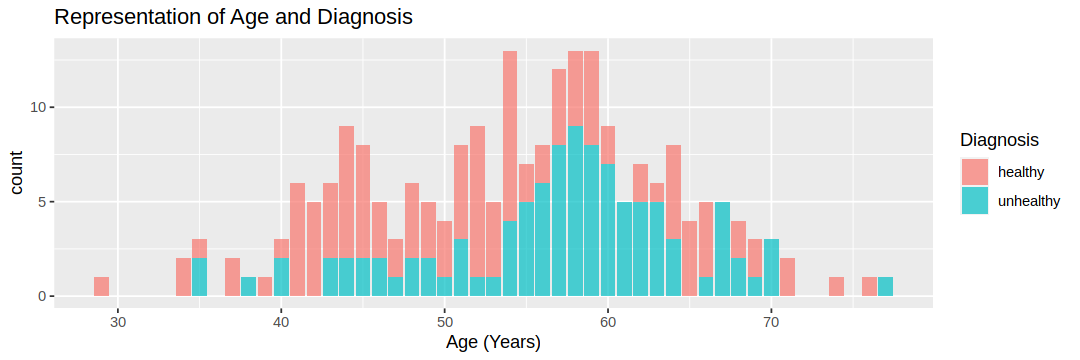

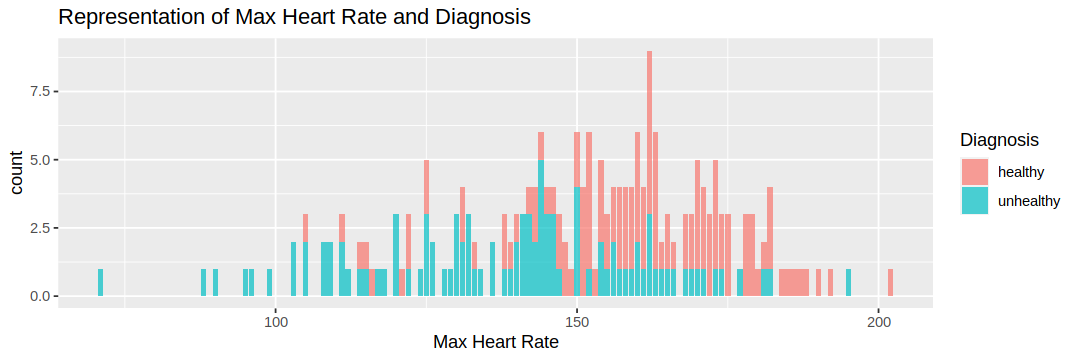

In [12]:
# A bar graph of each variable in relation to the diagnosis
# we have commented out all  our graphs but one for improved readability if we want to see said graphs we can uncomment the graph
options(repr.plot.width = 9, repr.plot.height = 3)

heart_disease_age_graph <- ggplot(heart_disease_training, aes(x = age, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Age and Diagnosis") + 
                           labs(x = "Age (Years)", fill = "Diagnosis", stat = "Count")
heart_disease_cp_graph <- ggplot(heart_disease_training, aes(x = cp, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Chest Pain Types and Diagnosis") + 
                           labs(x = "Chest Pain Types", fill = "Diagnosis", stat = "Count")
heart_disease_sex_graph <- ggplot(heart_disease_training, aes(x = sex, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Sex and Diagnosis") + 
                           labs(x = "Sex", fill = "Diagnosis", stat = "Count")
heart_disease_trestbps_graph <- ggplot(heart_disease_training, aes(x = trestbps, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Resting Blood Pressure and Diagnosis") + 
                           labs(x = "Resting Blood Pressure (mmHg)", fill = "Diagnosis", stat = "Count")
heart_disease_chol_graph <- ggplot(heart_disease_training, aes(x = chol, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Serum Cholesterol and Diagnosis") + 
                           labs(x = "Serum Cholesterol (mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_fbs_graph <- ggplot(heart_disease_training, aes(x = fbs, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Fasting Blood Sugar and Diagnosis") + 
                           labs(x = "Fasting Blood Sugar (> 120mg/dl)", fill = "Diagnosis", stat = "Count")
heart_disease_restecg_graph <- ggplot(heart_disease_training, aes(x = restecg, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Resting ECG Results and Diagnosis") + 
                           labs(x = "Resting ECG Results", fill = "Diagnosis", stat = "Count")
heart_disease_thalach_graph <- ggplot(heart_disease_training, aes(x = thalach, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of Max Heart Rate and Diagnosis") + 
                           labs(x = "Max Heart Rate", fill = "Diagnosis", stat = "Count")
heart_disease_exang_graph <- ggplot(heart_disease_training, aes(x = exang, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Exercised Induced Angina and Diagnosis") + 
                           labs(x = "Exercised Induced Angina", fill = "Diagnosis", stat = "Count")
heart_disease_oldpeak_graph <- ggplot(heart_disease_training, aes(x = oldpeak, fill = diagnosis)) + 
                           geom_histogram(stat = "count", alpha = 0.7) + 
                           ggtitle("Representation of ST Depression and Diagnosis") + 
                           labs(x = "ST Depression Relative To Rest", fill = "Diagnosis", stat = "Count")
heart_disease_slope_graph <- ggplot(heart_disease_training, aes(x = slope, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Slope of Peak Exercise ST and Diagnosis") + 
                           labs(x = "Slope of Peak Exercise ST", fill = "Diagnosis", stat = "Count")
heart_disease_ca_graph <- ggplot(heart_disease_training, aes(x = ca, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Number of Major Vessels and Diagnosis") + 
                           labs(x = "Number of Major Vessels Colored By Fluoroscopy", fill = "Diagnosis", stat = "Count")
heart_disease_thal_graph <- ggplot(heart_disease_training, aes(x = thal, fill = diagnosis)) + 
                           geom_histogram(stat = "count") + 
                           ggtitle("Representation of Defect Type and Diagnosis") + 
                           labs(x = "Defect Type", fill = "Diagnosis", stat = "Count")
heart_disease_age_graph
#heart_disease_cp_graph
#heart_disease_sex_graph
#heart_disease_trestbps_graph
#heart_disease_chol_graph
#heart_disease_fbs_graph
#heart_disease_restecg_graph
heart_disease_thalach_graph
#heart_disease_exang_graph
#heart_disease_oldpeak_graph
#heart_disease_slope_graph
#heart_disease_ca_graph
#heart_disease_thal_graph

comparison graph between age and thalach

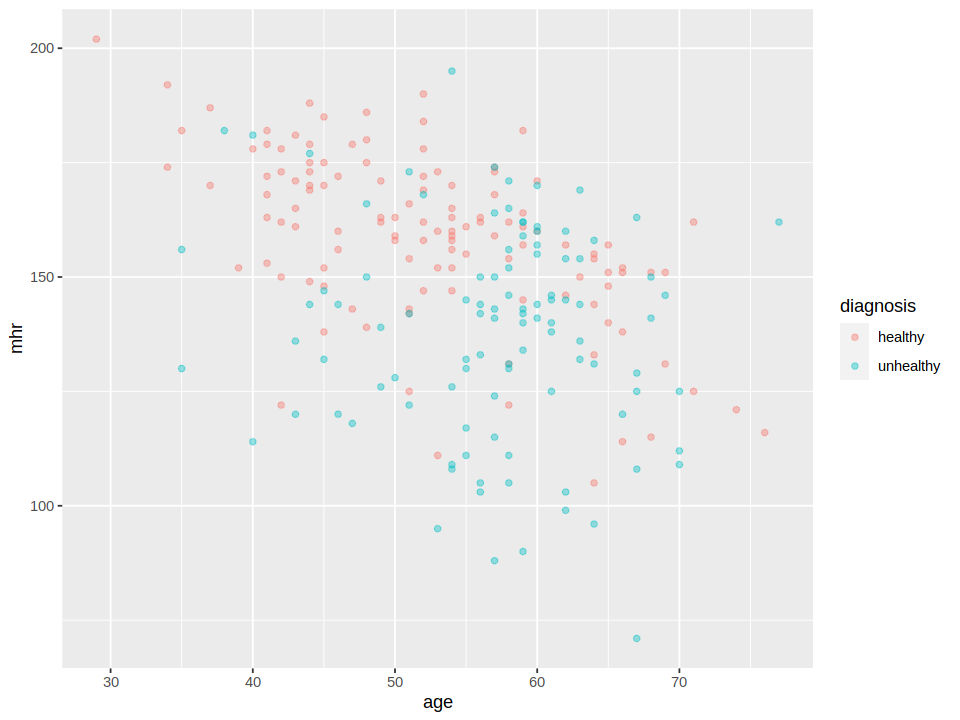

In [17]:
set.seed(3456)
options(repr.plot.width = 8, repr.plot.height = 6)
age_v_mhr <- ggplot(heart_disease_training, aes(x = age, y = thalach)) + 
             geom_point(aes(colour = diagnosis), alpha = 0.4) + 
             labs(x = "age", y = "mhr")
age_v_mhr

relationship?

# Classification

### Cross-fold Validation

In [20]:
heart_disease_recipe = recipe(diagnosis ~ ., select(heart_disease_training, -sex, -fbs)) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tuning = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

set.seed(3456)
heart_disease_vfold = vfold_cv(heart_disease_training, v = 5, strata = diagnosis)
k_vals = tibble(neighbors = seq(1, 29, 2))

tuning_workflow = workflow() |>
       add_recipe(heart_disease_recipe) |>
       add_model(knn_tuning) |>
       tune_grid(resamples = heart_disease_vfold, grid = k_vals)

tuning_metrics = tuning_workflow |>
    collect_metrics()

accuracies <- tuning_metrics |> 
    filter(.metric == "accuracy") |>
    select(neighbors, mean)
accuracies
options(repr.matrix.max.rows = 15)

neighbors,mean
<dbl>,<dbl>
1,0.7794949
3,0.8156566
5,0.8159596
7,0.8158586
9,0.8427273
11,0.8473737
13,0.8473737
15,0.8473737
17,0.8564646


Graph

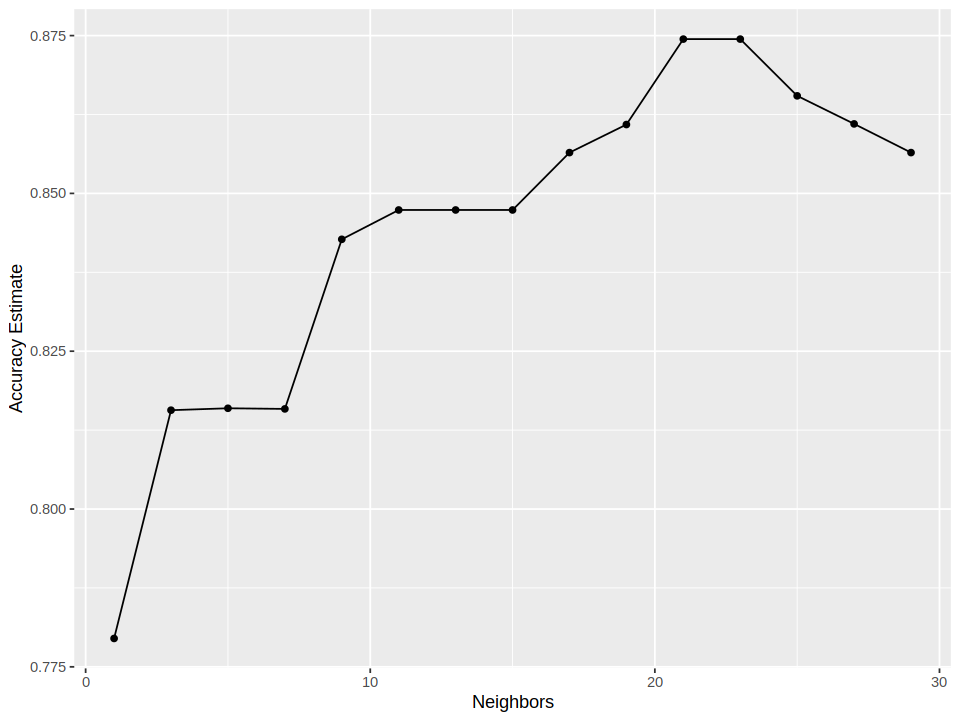

In [21]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

Finding testing average

Training set

In [22]:
set.seed(3456)

knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_disease_fit = workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec) |>
    fit(heart_disease_training)

heart_disease_train = heart_disease_fit |>
    predict(heart_disease_training) |>
    bind_cols(heart_disease_training)

heart_disease_conf_mat = heart_disease_train |>
    conf_mat(diagnosis, .pred_class)
heart_disease_conf_mat

heart_disease_accuracy = heart_disease_train |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()
heart_disease_accuracy

           Truth
Prediction  healthy unhealthy
  healthy       110        21
  unhealthy      10        81

[1] 0.8603604

Testing set

In [23]:
heart_disease_test = heart_disease_fit |>
    predict(heart_disease_testing) |>
    bind_cols(heart_disease_testing)

heart_disease_test_conf_mat = heart_disease_test |>
    conf_mat(diagnosis, .pred_class)
heart_disease_test_conf_mat

heart_disease_test_accuracy <- heart_disease_test |>
  metrics(truth = diagnosis, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
heart_disease_test_accuracy

           Truth
Prediction  healthy unhealthy
  healthy        36        14
  unhealthy       4        21

[1] 0.76